# Final Project for Introduction to Deep Learning
# Sentiment Analysis for Mental Health: Transformer for NLP

Mental health is a sensitive and important issue. Early detection and intervention can help prevent many tragedies. In this project, I aim to identify signs of mental health challenges by analyzing how individuals describe their feelings. By applying deep learning techniques in natural language processing (NLP), I hope to detect potential mental health concerns through simple written expressions. If successful, this approach could enable medical professionals to more easily recognize suspected cases and provide timely intervention. 

## 1. Introduction

The dataset is from Kaggle Data: Sentiment Analysis for Mental Health - Unlocking Mental Health Patterns through Statements ( https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health )
This comprehensive dataset is a meticulously curated collection of mental health statuses tagged from various statements. The dataset amalgamates raw data from multiple sources, cleaned and compiled to create a robust resource for developing chatbots and performing sentiment analysis.

#### Data Overview:
The dataset consists of statements tagged with one of the following seven mental health statuses:

- Normal
- Depression
- Suicidal
- Anxiety
- Stress
- Bi-Polar
- Personality Disorder

#### Data Collection:
The data is sourced from diverse platforms including social media posts, Reddit posts, Twitter posts, and more. Each entry is tagged with a specific mental health status, making it an invaluable asset for:

- Developing intelligent mental health chatbots.
- Performing in-depth sentiment analysis.
- Research and studies related to mental health trends.

#### Features:

- unique_id: A unique identifier for each entry.
- Statement: The textual data or post.
- Mental Health Status: The tagged mental health status of the statement.

#### Dataset:
The data set contain 1 csv file with 53043 rows X 3 columns.

#### Objective of study:
To correctly classify the text with the 7 Mental Health Status.

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud,STOPWORDS
from PIL import Image
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import nltk
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    log_loss,
    hamming_loss,
    matthews_corrcoef,
    zero_one_loss,
    jaccard_score,
    multilabel_confusion_matrix
)

nltk.download('vader_lexicon')
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df=pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")

In [4]:
mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/twitter.png"))

## 2. Data Preprocessing and EDA

The dataset is largely cleaned. I checked for null fields and removed the corresponding rows. Next, I plotted a histogram to examine the distribution of the status labels. The classes are imbalanced, at first I thought since I would be using a pretrained Transformer model, RoBERTa, this imbalance and minor imperfections in the data should not significantly affect the results.  But then after running my model and further research, I found that even for LLM like RoBERTa, class balance matter when we tailor training to our own model and here are the reasons:

- Bias in Training  
If one class dominates (say 90% positive, 10% negative), the model can achieve high accuracy by mostly predicting the majority class. This leads to poor performance on minority classes.
- Loss Function Sensitivity  
Standard loss functions (like cross-entropy) treat all samples equally. With imbalanced data, the loss is dominated by majority-class errors, so the model doesn’t learn minority-class patterns well.
- Evaluation Metrics   
Accuracy can be misleading in imbalanced datasets. Metrics like F1-score, precision, recall, AUC are more informative. BERT doesn’t magically fix this problem.


I then generated additional visualizations to better understand the dataset and gain confidence in the model. The graphs are quite intuitive: for example, the word count for the “Normal” status is the lowest, which makes sense as people tend to write less when everything feels fine. Common words such as “feel,” “know,” and “life” appear frequently across different plots. One interesting observation is the PCA projection of the statement vectors: while there are visible layers in the vector space, the boundaries between classes are highly mixed. Based on this, I expect the model will be able to roughly distinguish between statuses, though some errors are inevitable.

In [5]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.drop(columns=["Unnamed: 0"],axis=1,inplace=True)

In [7]:
df.shape

(53043, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [9]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [10]:
mode=df["statement"].mode()[0]
df["statement"]=df["statement"].fillna(mode)

In [11]:
df.isnull().sum()

statement    0
status       0
dtype: int64

In [12]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [13]:
df["status"].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

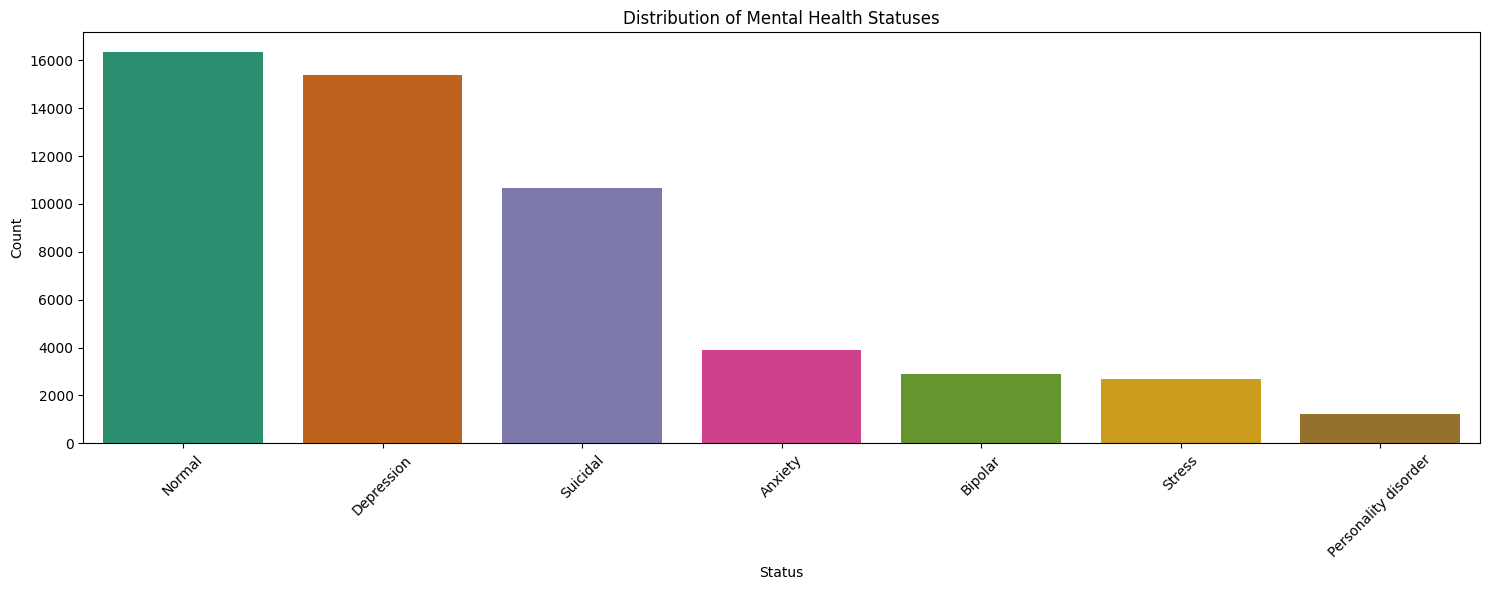

In [14]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, palette='Dark2')

plt.title('Distribution of Mental Health Statuses')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

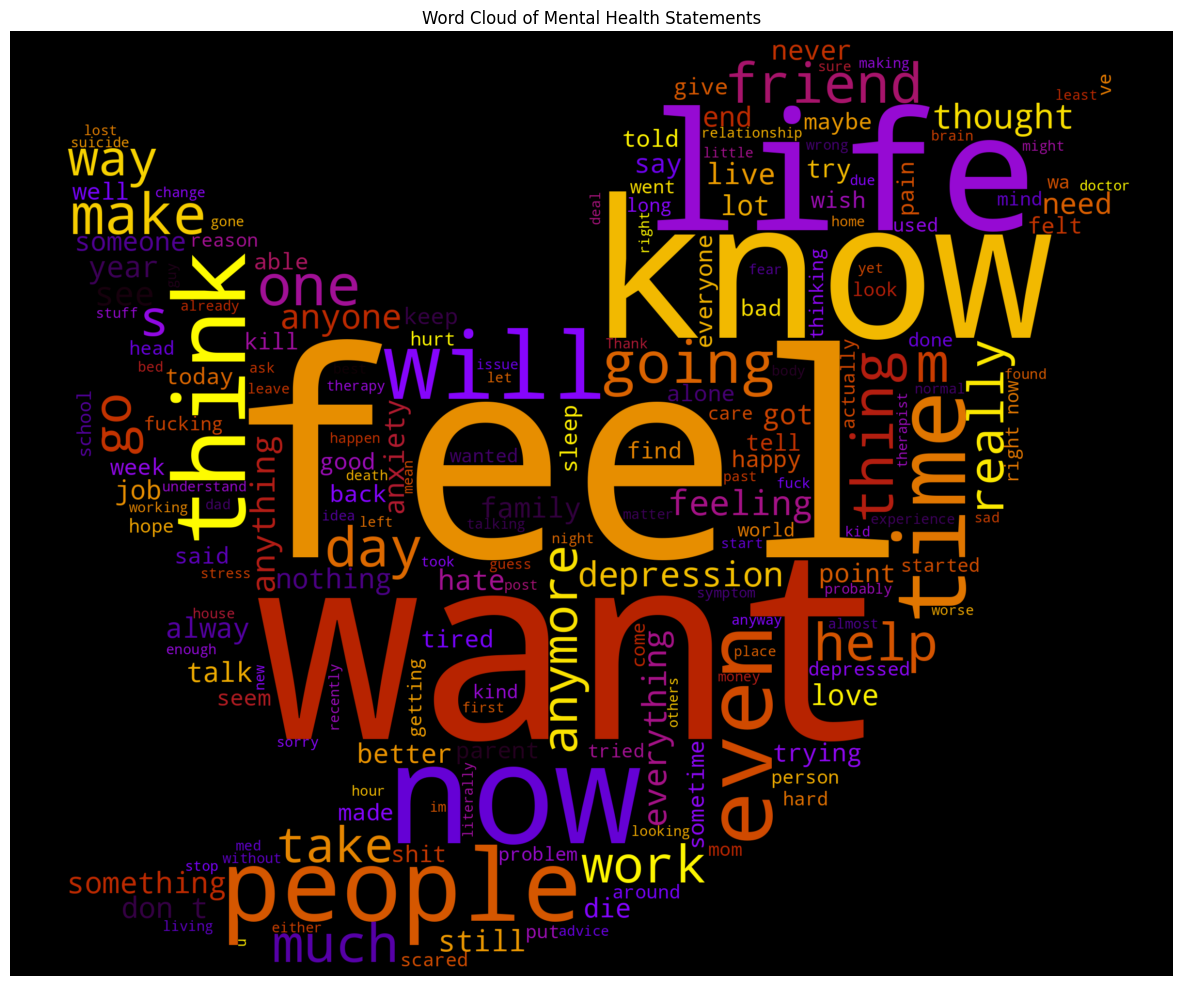

In [15]:
text = ' '.join(df['statement'])
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=800, height=600, background_color='black', min_font_size=10, 
                      stopwords=stopwords,mask=mask,colormap="gnuplot").generate(text)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Mental Health Statements')
plt.show()

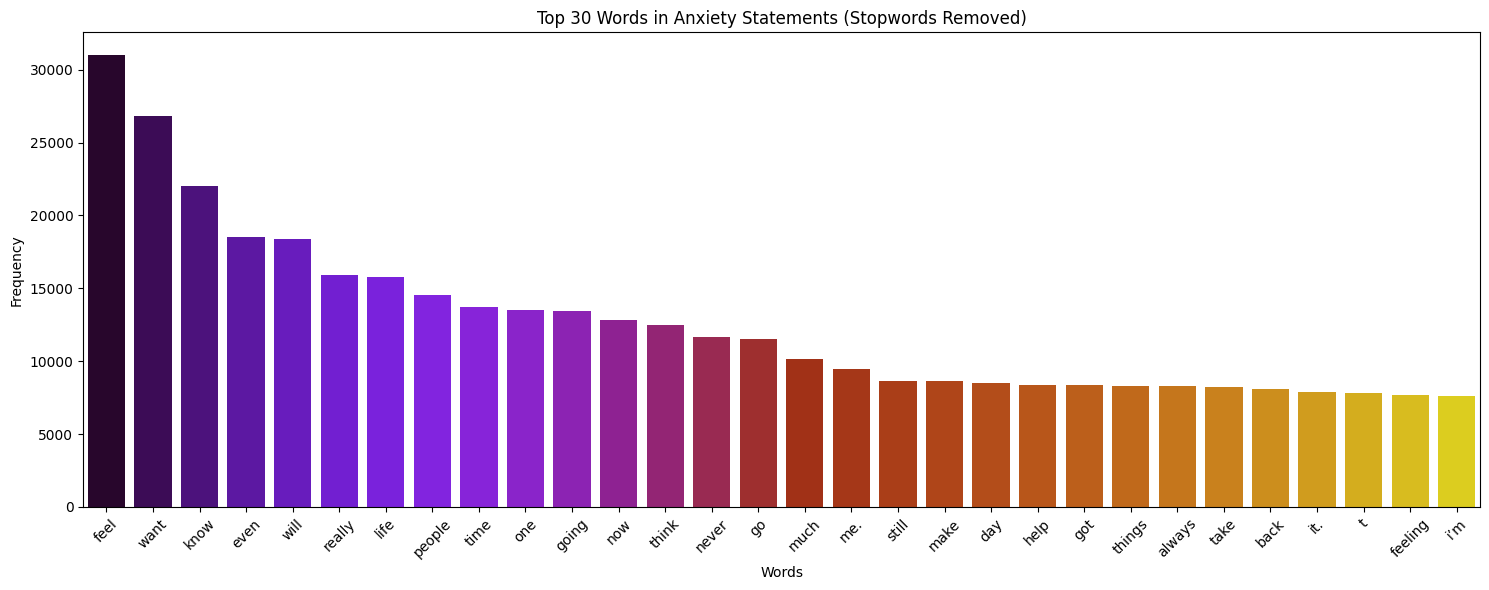

In [16]:
stopwords = set(STOPWORDS)
words = ' '.join(df['statement']).split()
filtered_words = [word.lower() for word in words if word.lower() not in stopwords]

word_counts = Counter(filtered_words)
top_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:30])

top_words_df = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency'])
plt.figure(figsize=(15, 6))
sns.barplot(data=top_words_df, x='Word', y='Frequency', palette='gnuplot')
plt.title('Top 30 Words in Anxiety Statements (Stopwords Removed)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

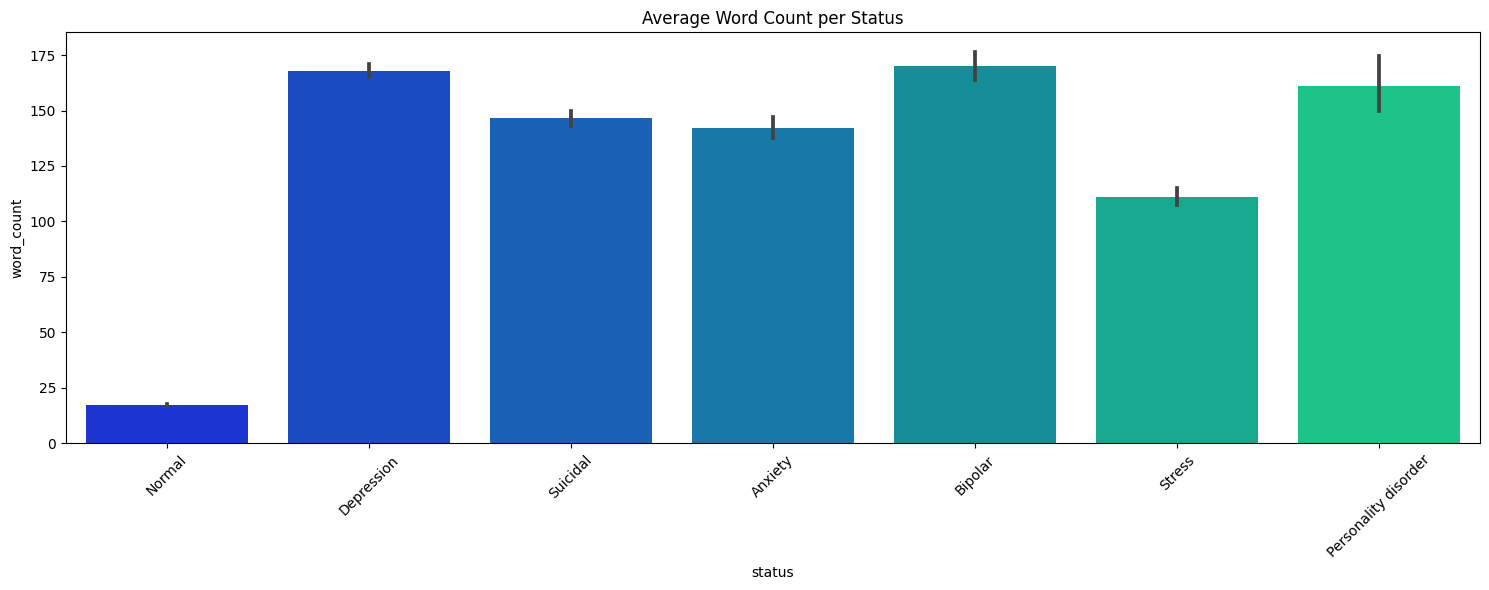

In [17]:
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))
plt.figure(figsize=(15, 6))
sns.barplot(x='status', y='word_count', data=df, estimator=np.mean, order=df['status'].value_counts().index,palette="winter")
plt.title('Average Word Count per Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


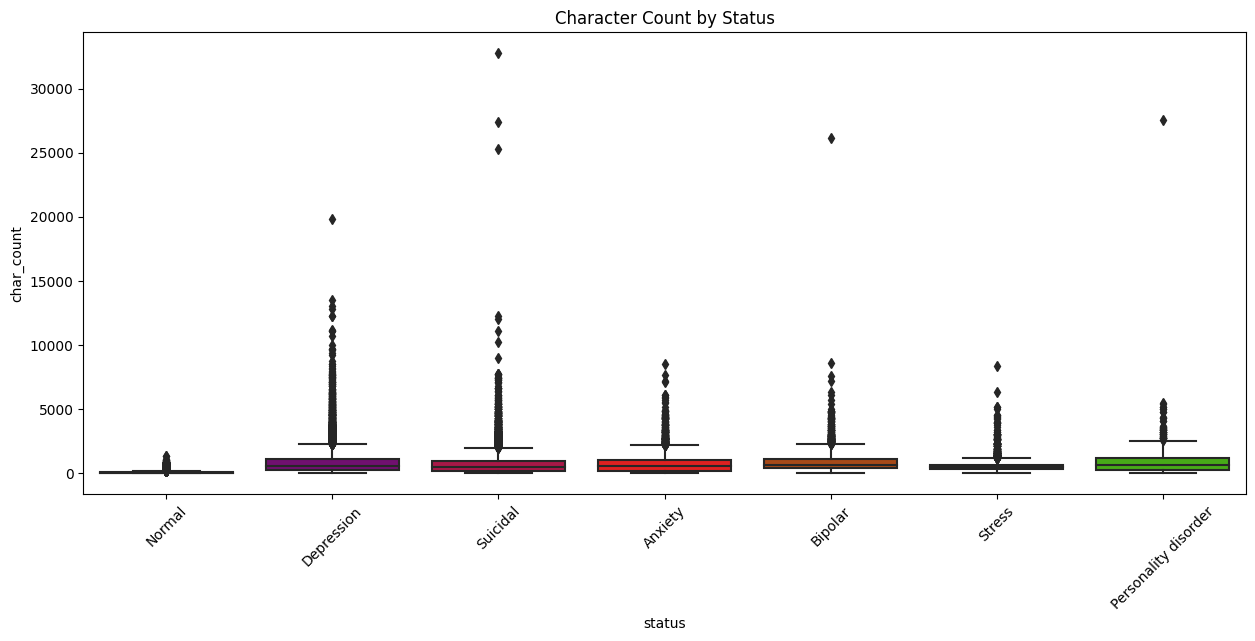

In [18]:
df['char_count'] = df['statement'].apply(len)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='status', y='char_count', order=df['status'].value_counts().index, palette='brg')
plt.title('Character Count by Status')
plt.xticks(rotation=45)
plt.show()

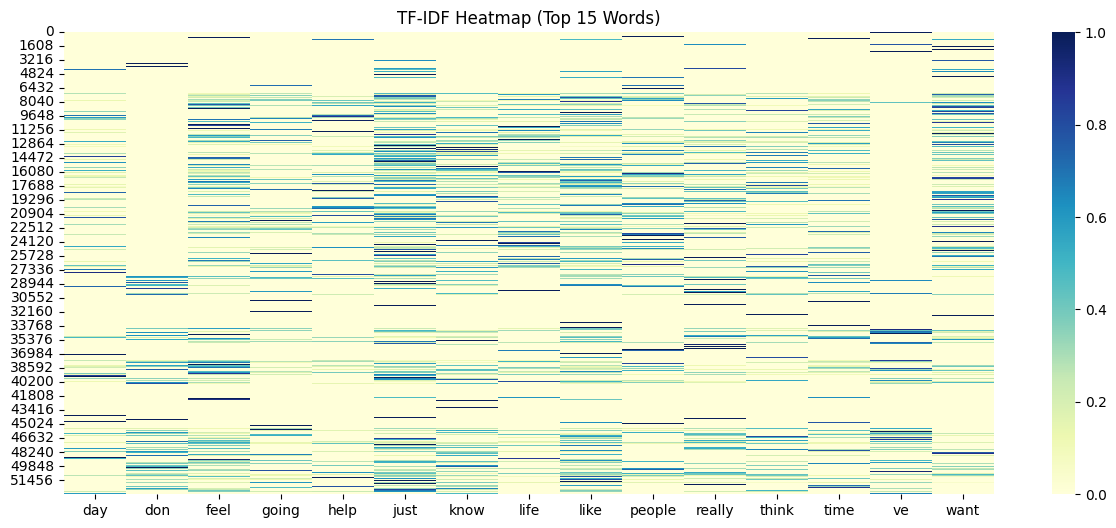

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=15, stop_words='english')
X = tfidf.fit_transform(df['statement'])
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

plt.figure(figsize=(15, 6))
sns.heatmap(tfidf_df, cmap='YlGnBu')
plt.title('TF-IDF Heatmap (Top 15 Words)')
plt.show()

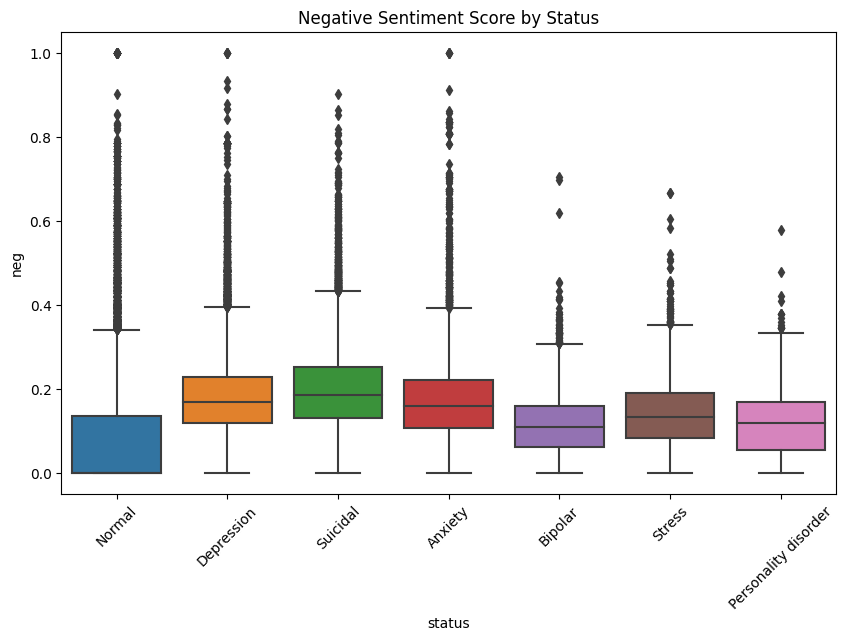

In [20]:
sid = SentimentIntensityAnalyzer()

df['neg'] = df['statement'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['pos'] = df['statement'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['neu'] = df['statement'].apply(lambda x: sid.polarity_scores(x)['neu'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='status', y='neg', order=df['status'].value_counts().index)
plt.title('Negative Sentiment Score by Status')
plt.xticks(rotation=45)
plt.show()

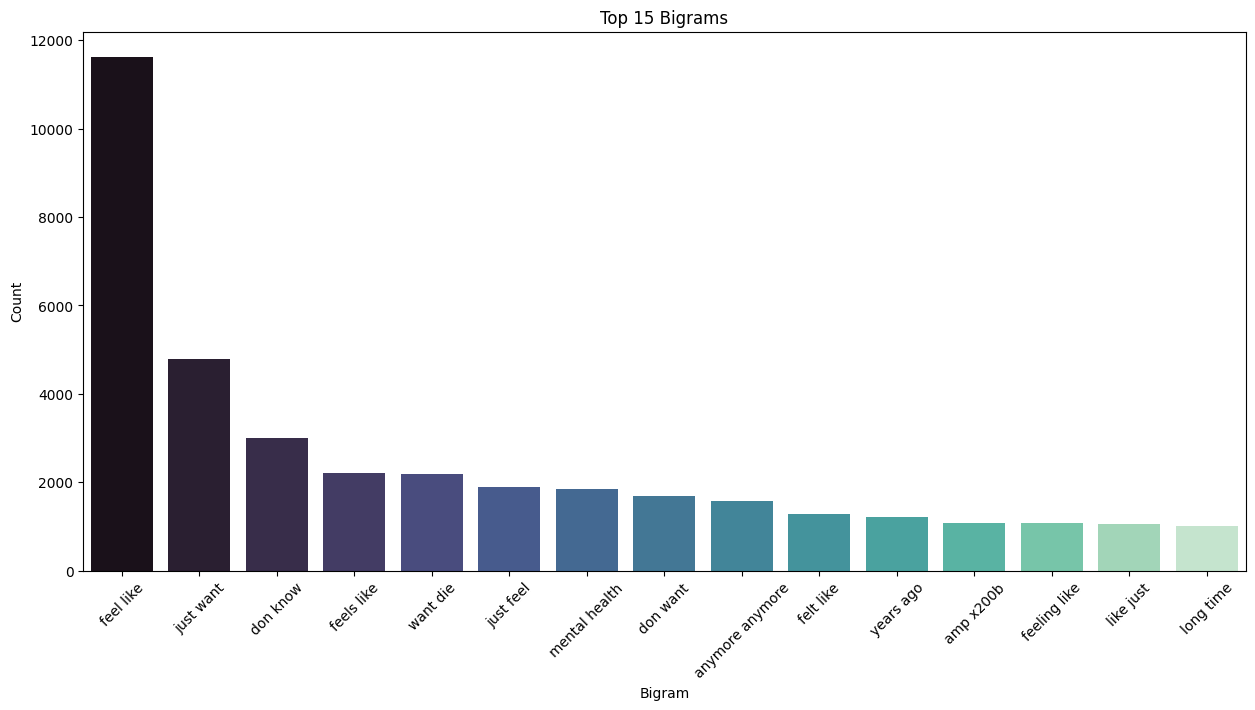

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = vec.fit_transform(df['statement'])
sum_bigrams = bigrams.sum(axis=0)
bigram_freq = [(word, sum_bigrams[0, idx]) for word, idx in vec.vocabulary_.items()]
top_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:15]

bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
plt.figure(figsize=(15,7))
sns.barplot(data=bigram_df, x='Bigram', y='Count', palette='mako')
plt.xticks(rotation=45)
plt.title('Top 15 Bigrams')
plt.show()

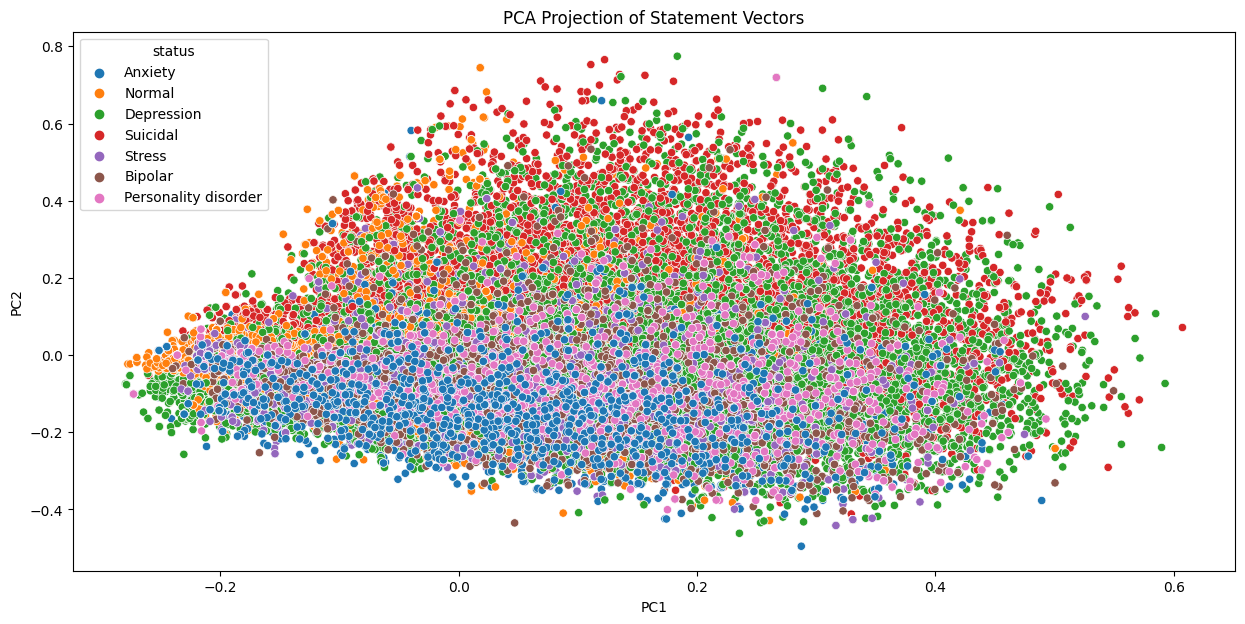

In [22]:
from sklearn.decomposition import PCA

tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X = tfidf.fit_transform(df['statement'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['status'] = df['status'].values

plt.figure(figsize=(15, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='status', palette='tab10')
plt.title('PCA Projection of Statement Vectors')
plt.show()


In [23]:
df.head()

,statement,status,word_count,char_count,neg,pos,neu
0,oh my gosh,Anxiety,3,10,0.000,0.000,1.000
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,0.504,0.000,0.496
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,0.480,0.127,0.392
3,I've shifted my focus to something else but I'...,Anxiety,11,61,0.219,0.000,0.781
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,0.276,0.000,0.724


## 3. The Model Architecture

In this project, I used a pretrained model from the Hugging Face Transformers library. The RobertaForSequenceClassification model is readily available, so I simply wrapped it with input and output layers and trained the necessary parameters. RoBERTa is a more recent large language model compared to BERT, and it delivers strong performance. For NLP tasks, there are many pretrained models such as BERT and GPT that can be applied with ease, and Hugging Face conveniently provides a wide selection of them. These pretrained models require far less training time than building a model from scratch, while often achieving superior results. Although implementing a model from scratch is valuable for learning the fundamentals, in practice I prefer to rely on pretrained models since they are both efficient and effective.


#### model preparation

First I upload the AutoTokenizer and RobertaForSequenceClassification.  Then, I do some further preprocess like changing the status into numbers, tokenize the text and split the data into 80-10-10  train-validation-test split.

In [24]:
from transformers import AutoTokenizer, RobertaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base",num_labels=7)
model.to(device)

2025-12-01 15:31:03.775467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764603064.031919      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764603064.092887      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [25]:
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
le=LabelEncoder()
df["label"]=le.fit_transform(df["status"])
print(dict(zip(le.classes_,range(len(le.classes_)))))

{'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [26]:
def tokenize_function(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True, max_length=128)
dataset = Dataset.from_pandas(df[["statement", "label"]])
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/53043 [00:00<?, ? examples/s]

In [27]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
train_dataset = Dataset.from_pandas(train_df[["statement", "label"]]).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df[["statement", "label"]]).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df[["statement", "label"]]).map(tokenize_function, batched=True)

Map:   0%|          | 0/42434 [00:00<?, ? examples/s]

Map:   0%|          | 0/5304 [00:00<?, ? examples/s]

Map:   0%|          | 0/5305 [00:00<?, ? examples/s]

#### Change the data into Torch format


In [ ]:
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Load the necessary library
#### Set out the hyperparameter
#### Run the training loop

I added early stopping in the training loop.  You can see from the run, the training stopped at the seventh epoch.  I also recorded the measurement figures so that I can plot graphs to see how the training goes afterwards.  And look into the numbers, you can see the validation loss start to increase in epoch 5th.  I set the training to run 10 epoches, but it early stopped at epoch 7th.

In [30]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from tabulate import tabulate
import time

optimizer = AdamW(model.parameters(), lr=0.00002)
num_epochs = 10
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)


loss_fn = nn.CrossEntropyLoss().to(device)



In [31]:
metrics_table = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float("inf")
patience = 5
patience_counter = 0

# Start total runtime measurement
total_start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Training Loop
    train_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        train_correct += torch.sum(preds == labels).item()
        train_total += labels.size(0)
    
    train_end_time = time.time()
    train_time = train_end_time - train_start_time
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation Loop
    val_start_time = time.time()
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_end_time = time.time()
    val_time = val_end_time - val_start_time
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    # Calculate total epoch time
    epoch_time = train_time + val_time
    
    # Store metrics with times for tabulate
    metrics_table.append([
        epoch + 1,
        f"{avg_train_loss:.4f}",
        f"{train_accuracy:.4f}",
        f"{avg_val_loss:.4f}",
        f"{val_accuracy:.4f}",
        f"{val_f1:.4f}",
        f"{train_time:.2f}s",
        f"{val_time:.2f}s",
        f"{epoch_time:.2f}s"
    ])
    
    # Print metrics using tabulate
    headers = ["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy", "Val F1", "Train Time", "Val Time", "Epoch Time"]
    print("\nMetrics:")
    print(tabulate(metrics_table, headers=headers, tablefmt="grid"))
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        model.save_pretrained("/kaggle/working/best_roberta_emotion")
        tokenizer.save_pretrained("/kaggle/working/best_roberta_emotion")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Calculate and print total runtime
total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f"\nTotal Training Time: {total_time // 60:.0f}m {total_time % 60:.2f}s")


Epoch 1/10


Validation: 100%|██████████| 166/166 [00:17<00:00,  9.30it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+

Epoch 2/10


Validation: 100%|██████████| 166/166 [00:17<00:00,  9.29it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3848 |           0.8395 |     0.4045 |         0.8265 |   0.8278 | 517.43s      | 17.87s     | 535.30s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+

Epoch 3/10


Validation: 100%|██████████| 166/166 [00:17<00:00,  9.29it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3848 |           0.8395 |     0.4045 |         0.8265 |   0.8278 | 517.43s      | 17.87s     | 535.30s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3104 |           0.8704 |     0.4276 |         0.829  |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.30it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3848 |           0.8395 |     0.4045 |         0.8265 |   0.8278 | 517.43s      | 17.87s     | 535.30s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3104 |           0.8704 |     0.4276 |         0.829  |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.29it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3848 |           0.8395 |     0.4045 |         0.8265 |   0.8278 | 517.43s      | 17.87s     | 535.30s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3104 |           0.8704 |     0.4276 |         0.829  |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.29it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3848 |           0.8395 |     0.4045 |         0.8265 |   0.8278 | 517.43s      | 17.87s     | 535.30s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3104 |           0.8704 |     0.4276 |         0.829  |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.29it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5697 |           0.7729 |     0.4397 |         0.8183 |   0.8175 | 517.57s      | 17.86s     | 535.43s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3848 |           0.8395 |     0.4045 |         0.8265 |   0.8278 | 517.43s      | 17.87s     | 535.30s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3104 |           0.8704 |     0.4276 |         0.829  |   0.

#### Save the model

In [32]:
import os
save_path = "/kaggle/working/save_roberta_model"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)


In [33]:
ls /kaggle/working/save_roberta_model

config.json  model.safetensors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 4. Result and analysis

#### Plotting the training measurements
We can see the validation loss start to rise at epoch 5.  The training accuracy is increasing, but the validation accuracy start to drop at epoch 7.  That means it start to have over fitting and early stopping take place here.

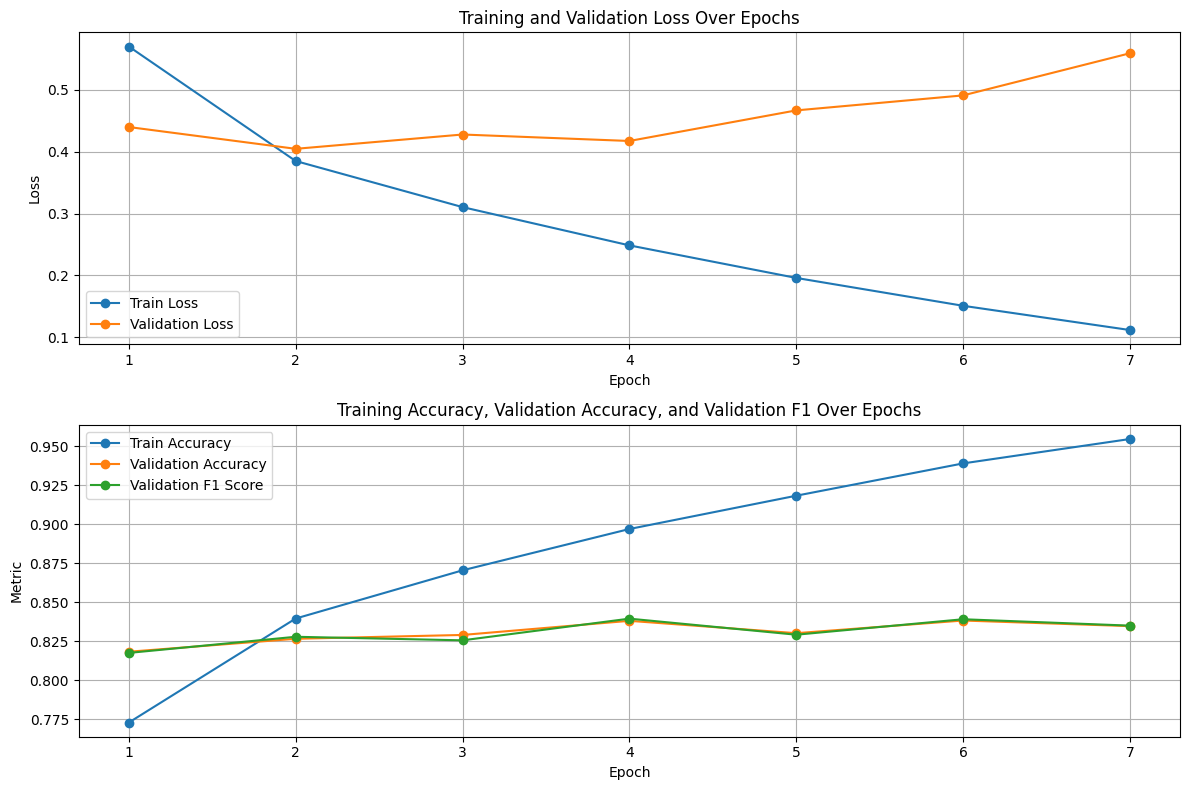

In [34]:
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy and F1
plt.subplot(2, 1, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label="Validation F1 Score", marker="o")
plt.title("Training Accuracy, Validation Accuracy, and Validation F1 Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
label_name=['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']

#### Apply the model to the testing set

As you can see from the Classification report, the test run has accuracy is 0.8354 which is not bad for the model.

When we look at the Confusion Matrix, most data fall into the diagonal which is correct prediction.  However, i notice that for the status "Depression" and "Suicidal" There are a lot of wrong case and these two status are mixed up both false positive and false negative.   If you remember the PCA Projection graph I plotted earlier, these two status is very mixed up.  That's why I predicted the model will have this kind of error.  And in common sense, the description of these two Mental Health problem will be easily confuse even by human.  Therefore, the result is reasonable.  I also plotted the precision recall curve and the ROE curve.  Both curves look good and we have evidence that the model is good.

In [36]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        test_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        test_correct += torch.sum(preds == labels).item()
        test_total += labels.size(0)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate average loss and metrics
avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = test_correct / test_total
test_f1 = f1_score(test_labels, test_preds, average="weighted")

# Print summary table
print("\nTest Metrics:")
print(tabulate([[avg_test_loss, test_accuracy, test_f1]],
               headers=["Test Loss", "Test Accuracy", "Test F1"],
               tablefmt="grid"))

# Print full classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, digits=4,target_names=label_name))


Testing: 100%|██████████| 166/166 [00:17<00:00,  9.34it/s]



Test Metrics:
+-------------+-----------------+-----------+
|   Test Loss |   Test Accuracy |   Test F1 |
+=============+=================+===========+
|    0.552126 |        0.835438 |  0.835889 |
+-------------+-----------------+-----------+

Detailed Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.9079    0.9079    0.9079       380
             Bipolar     0.8688    0.8750    0.8719       280
          Depression     0.8081    0.7540    0.7801      1581
              Normal     0.9588    0.9670    0.9629      1635
Personality disorder     0.6503    0.7623    0.7019       122
              Stress     0.8129    0.7820    0.7972       289
            Suicidal     0.6831    0.7367    0.7089      1018

            accuracy                         0.8354      5305
           macro avg     0.8128    0.8264    0.8187      5305
        weighted avg     0.8375    0.8354    0.8359      5305



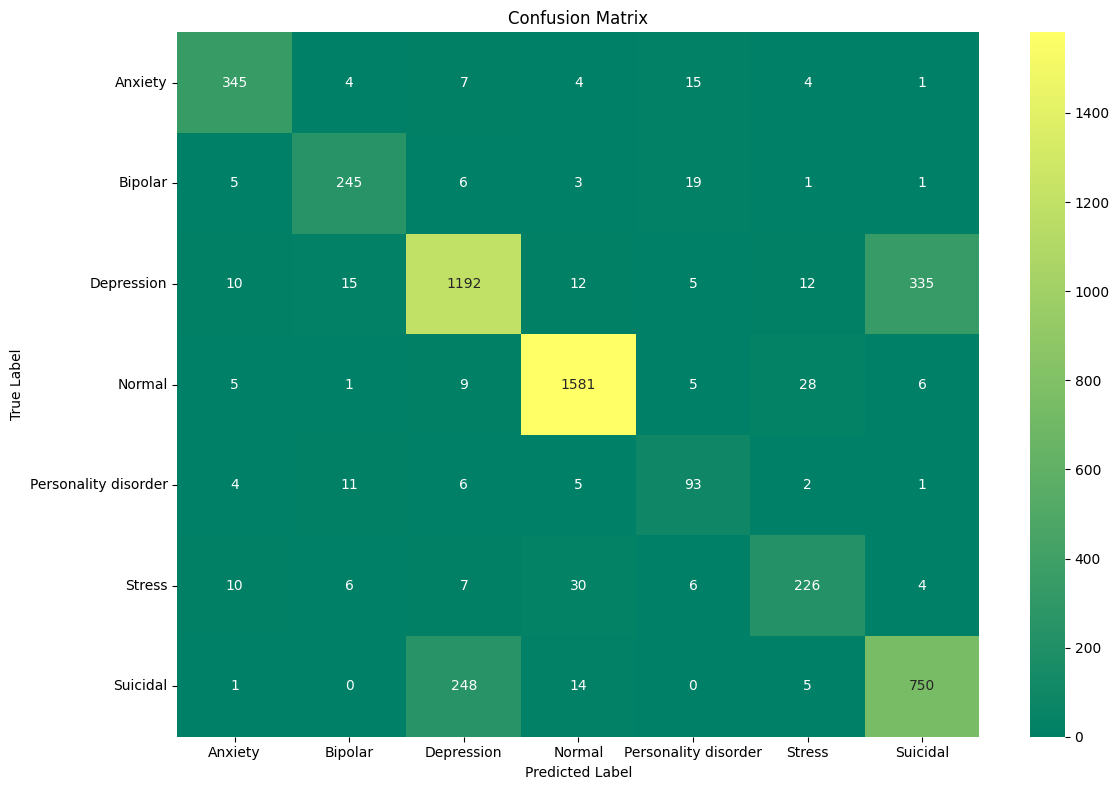

In [37]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="summer", xticklabels=label_name, yticklabels=label_name)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Testing: 100%|██████████| 166/166 [00:17<00:00,  9.35it/s]


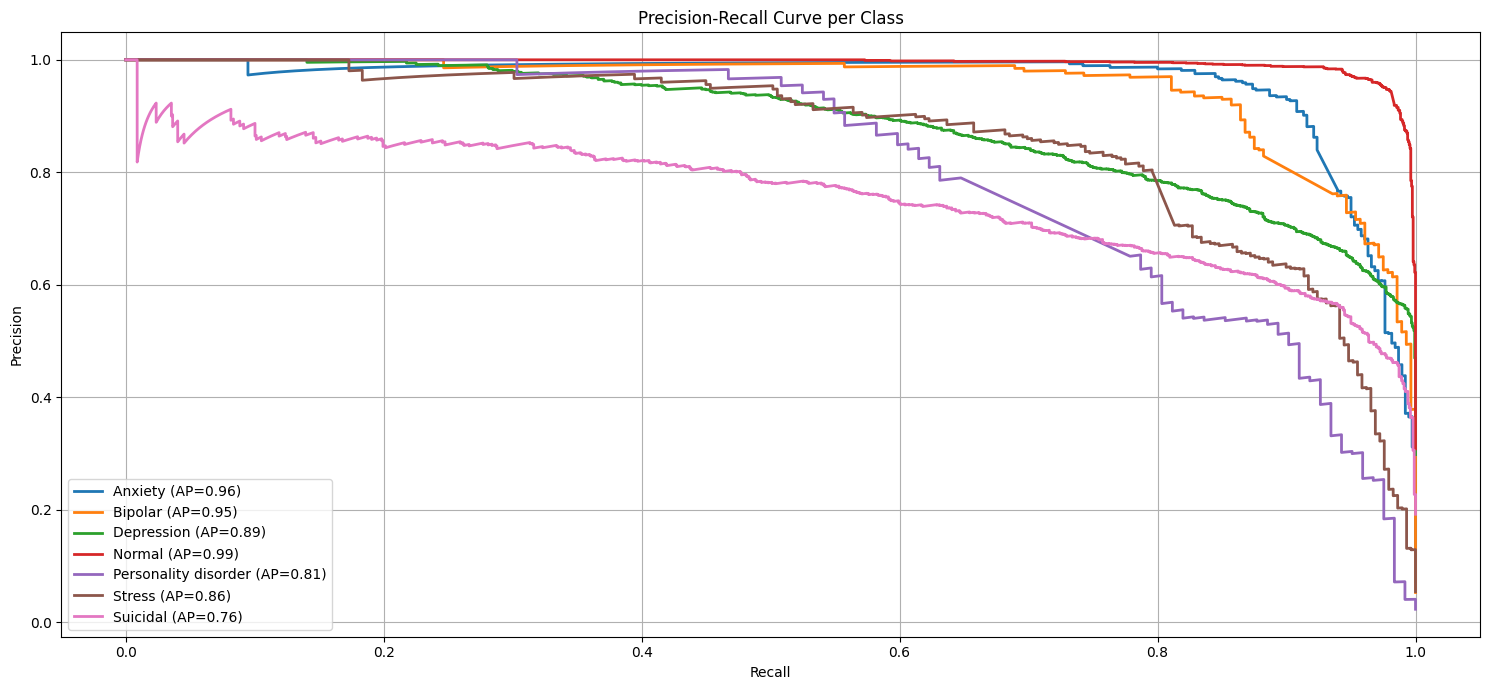

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

import torch.nn.functional as F

test_probs = []
test_preds = []
test_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)  # <-- probabilities per class

        _, preds = torch.max(logits, dim=1)
        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


num_classes = len(label_name)
y_true_bin = label_binarize(test_labels, classes=list(range(num_classes)))
y_score = np.array(test_probs)  # predicted probabilities

# Plot Precision-Recall curve for each class
plt.figure(figsize=(15, 7))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    avg_prec = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'{label_name[i]} (AP={avg_prec:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

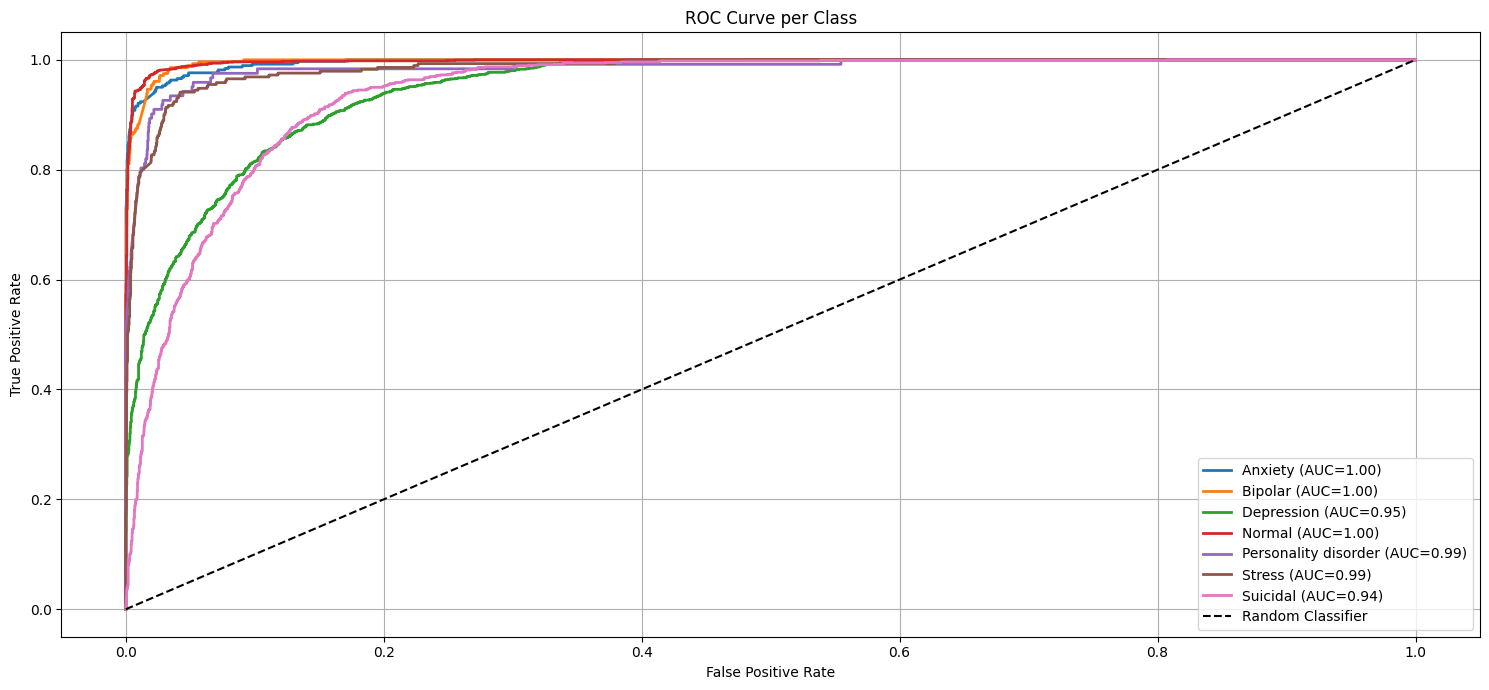

In [39]:
y_true_bin = label_binarize(test_labels, classes=list(range(num_classes)))
y_score = np.array(test_probs)

plt.figure(figsize=(15, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{label_name[i]} (AUC={auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, cohen_kappa_score, log_loss
)

num_classes = len(np.unique(test_labels))
y_true_bin = label_binarize(test_labels, classes=list(range(num_classes)))
y_score = np.array(test_probs)

print("=== Classification Metrics ===")
print(f"Accuracy         : {accuracy_score(test_labels, test_preds):.4f}")
print(f"F1 Score (Macro) : {f1_score(test_labels, test_preds, average='macro'):.4f}")
print(f"Recall (Macro)   : {recall_score(test_labels, test_preds, average='macro'):.4f}")
print(f"Precision (Macro): {precision_score(test_labels, test_preds, average='macro'):.4f}")
print(f"ROC AUC Score    : {roc_auc_score(y_true_bin, y_score, average='macro'):.4f}")
print(f"Cohen Kappa Score: {cohen_kappa_score(test_labels, test_preds):.4f}")
print(f"Log Loss         : {log_loss(y_true_bin, y_score):.4f}")

=== Classification Metrics ===
Accuracy         : 0.8354
F1 Score (Macro) : 0.8187
Recall (Macro)   : 0.8264
Precision (Macro): 0.8128
ROC AUC Score    : 0.9787
Cohen Kappa Score: 0.7863
Log Loss         : 0.5526


In [41]:
def predict_batch_statements(texts, model, tokenizer, device):
    model.eval()
 
    inputs = tokenizer(texts,padding="max_length",truncation=True,max_length=128,return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_idxs = torch.argmax(probs, dim=1).cpu().numpy()
        confidences = probs.max(dim=1).values.cpu().numpy()

    results = []
    for idx, conf in zip(pred_idxs, confidences):
        results.append((label_name[idx], conf))
    return results


model.to(device)

texts = [
    "I feel constant worry and nervousness all day.",               # Anxiety
    "My moods change dramatically and unpredictably.",               # Bipolar
    "I’ve been feeling very sad and hopeless lately.",               # Depression
    "I’m doing well and feel balanced emotionally.",                 # Normal
    "I often find it hard to relate to others and myself.",          # Personality disorder
    "Work pressure and daily life stress are overwhelming me.",      # Stress
    "Sometimes I think life isn’t worth living anymore.",             # Suicidal
]

predictions = predict_batch_statements(texts, model, tokenizer, device)
for text, (label, conf) in zip(texts, predictions):
    print(f"Text: {text}\nPredicted: {label} (confidence: {conf:.4f})\n")


Text: I feel constant worry and nervousness all day.
Predicted: Anxiety (confidence: 0.9986)

Text: My moods change dramatically and unpredictably.
Predicted: Normal (confidence: 0.9970)

Text: I’ve been feeling very sad and hopeless lately.
Predicted: Depression (confidence: 0.9751)

Text: I’m doing well and feel balanced emotionally.
Predicted: Normal (confidence: 0.9758)

Text: I often find it hard to relate to others and myself.
Predicted: Normal (confidence: 0.9865)

Text: Work pressure and daily life stress are overwhelming me.
Predicted: Stress (confidence: 0.9797)

Text: Sometimes I think life isn’t worth living anymore.
Predicted: Depression (confidence: 0.8514)



##  5. Conclusion

In conlusion to show how the model works, I input some text and to see if my model can classify them.  And it gives the result we see in our test data:

- The Personality Disorder and Bipolar is not well predicted.  
- Confusion with Depression and Suicidal.

For the first problem, it maybe due to the imbalance class problem at training as I mentioned earlier.  If I got to retrain the model next time, there are following methods to improve the imbalance:

- Resampling
- Oversample minority classes (e.g., SMOTE, simple duplication).
- Undersample majority classes.
- Class Weights  
Adjust loss function weights so errors on minority classes count more.
- Data Augmentation  
For text, paraphrasing or back-translation can increase minority samples.
- Evaluation Adjustments  
Use metrics like macro-F1 or balanced accuracy to reflect performance across all classes.

All in all, we can better fine tune the model by changing the input and output layers.  However, since this is a pretrained model, it runs in around 1 hour and the result is already pretty good.

GitHub link: https://github.com/samnyyow/Final_Project_Intro_to_Deep_Learning